# Visualizing weights with captum.optim

This notebook demonstrates the use of the captum.optim submodule for visualizing the weights of the InceptionV1 model imported from Caffe.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

For convenience, we can create helper functions for visualizing the weights of our model.


In [4]:
import numpy as np
import matplotlib.pyplot as plt


def resize_image(x: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x).permute(2, 1, 0).unsqueeze(0)
    x = torch.nn.functional.interpolate(x, size=(224,224), mode='bilinear')
    x = x.squeeze(0).permute(2, 1, 0).numpy()
    return x


def show(x: np.ndarray, resize: bool = False, scale: float = 255.0) -> None:
    assert x.ndim == 3
    if resize:
        x = resize_image(x)
    if x.shape[2] == 1:
        x = np.concatenate([x, x, x], 2)
    x = x * scale
    plt.imshow(x.astype(np.uint8))
    plt.axis("off")
    plt.show()


def weight_heatmap(array: np.ndarray) -> np.ndarray:
    def C(x: str) -> np.ndarray:
        def H(x: str) -> float:
            return int(x, 16) / 255.0

        return np.asarray([H(x[0:2]), H(x[2:4]), H(x[4:6])])

    def weight_color_scale(x: np.float32) -> np.float32:
        if x < 0:
            x = -x
            if x < 0.5:
                x = x * 2
                return (1 - x) * C("f7f7f7") + x * C("92c5de")
            else:
                x = (x - 0.5) * 2
                return (1 - x) * C("92c5de") + x * C("0571b0")
        else:
            if x < 0.5:
                x = x * 2
                return (1 - x) * C("f7f7f7") + x * C("f4a582")
            else:
                x = (x - 0.5) * 2
                return (1 - x) * C("f4a582") + x * C("ca0020")

    return np.asarray([[weight_color_scale(x) for x in a] for a in array])


def visualize_activations(model, target, channel: int, neuron=True) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )
    if neuron:
        loss_fn = optimviz.loss.NeuronActivation(target, channel)
    else:
        loss_fn = optimviz.loss.ChannelActivation(target, channel)
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    image().show()

## Extracting expanded weights

We can extract expanded weights with Captum.optim's get_expanded_weights function.

Below we extract the expanded weights from between the mixed3a and mixed3b layers:

In [5]:
W_3a_3b = optimviz.circuits.get_expanded_weights(model, model.mixed3a, model.mixed3b)
W_3a_3b_np = W_3a_3b.permute(1, 2, 0, 3).numpy() # Convert output to NumPy format

# Visualizing expanded weights

We can visualize our newly collected expanded weights for channel 147 of mixed3a and channel 379 of mixed3b like so:

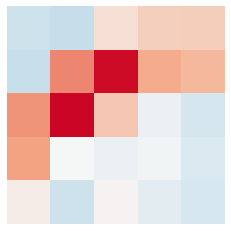

In [7]:
W_3a_3b_hm = weight_heatmap(W_3a_3b_np[:,:,147,379] / W_3a_3b_np[:,:,:,379].max())
W_3a_3b_hm = W_3a_3b_hm[11:16, 11:16, :]  # crop away border
show(W_3a_3b_hm)

By looking at the weights above, we can see how the the following two curve dectector neurons are connected to each other.

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:775: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:848.)
  return super(Tensor, self).refine_names(names)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sam

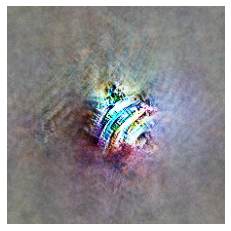

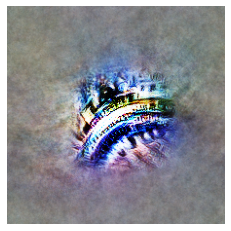

In [ ]:
visualize_activations(model, model.mixed3a, 147)
visualize_activations(model, model.mixed3b, 379)

# NMF Visualizations of expanded weights

NMF and other dimensionality reduction alorgrithms can reveal the spaital structure of weights.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


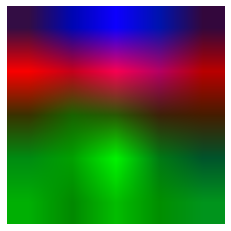

In [8]:
reducer = optimviz.ChannelReducer(3)

W_3a_3b_posneg = np.concatenate([np.maximum(0, W_3a_3b_np), np.maximum(0, -W_3a_3b_np)], axis=2)

W_nmf = reducer.fit_transform(W_3a_3b_posneg[..., 320], reshape=False)
W_nmf /= W_nmf.max()
W_nmf = W_nmf[11:16, 11:16, :]  # crop away border
show(W_nmf, resize=True)

Using the weights above, we can see how that they match the structure of the target neurons when they are visualized.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


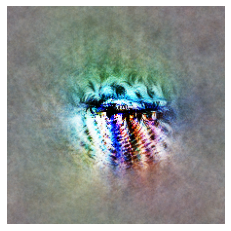

In [ ]:
visualize_activations(model, model.mixed3b, 320)